In [2]:
import torch
import torch.nn as nn 
import torch.optim as optim

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [3]:
def load_data(batch_size=32):
    transform = transforms.Compose([
        transforms.ToTensor(), # Convert images to PyTorch tensors
        transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)) # Normalize to [-1, 1]
    ])
    
    train_dataset = datasets.CIFAR10(root="./data", train=True, transform=transform,
    download=True)
    test_dataset = datasets.CIFAR10(root="./data", train=False, transform=transform,
    download=True)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader

In [4]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2), 
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2) 
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(64 * 8 * 8, 128),  
            nn.ReLU(),                  
            nn.Linear(128, 10),        
            nn.Softmax(dim=1)          
        )

    def forward(self, x):
        x = self.features(x) 
        x = torch.flatten(x, 1)
        x = self.classifier(x) 

        return x 

In [5]:
train_loader, test_loader = load_data()

100%|██████████| 170498071/170498071 [00:10<00:00, 16152954.83it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
# Example code snippet from the lesson
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

loss_per_epoch = []
val_loss_per_epoch = []

for epoch in range(10):
    running_loss = 0.0
    
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    mean_loss = running_loss / len(train_loader)
    loss_per_epoch.append(mean_loss) 

    model.eval() 
    val_running_loss = 0.0
    with torch.no_grad():  
        for val_images, val_labels in test_loader:
            val_outputs = model(val_images)
            val_loss = criterion(val_outputs, val_labels)
            val_running_loss += val_loss.item()

    val_mean_loss = val_running_loss / len(test_loader)
    val_loss_per_epoch.append(val_mean_loss)

    print(f"Epoch {epoch+1}, Training Loss: {mean_loss:.4f}, Validation Loss: {val_mean_loss:.4f}")

Epoch 1, Training Loss: 2.0269, Validation Loss: 1.9402
Epoch 2, Training Loss: 1.9112, Validation Loss: 1.9085
Epoch 3, Training Loss: 1.8597, Validation Loss: 1.8894
Epoch 4, Training Loss: 1.8200, Validation Loss: 1.8296
Epoch 5, Training Loss: 1.7905, Validation Loss: 1.8156
Epoch 6, Training Loss: 1.7722, Validation Loss: 1.8175
Epoch 7, Training Loss: 1.7513, Validation Loss: 1.8063
Epoch 8, Training Loss: 1.7362, Validation Loss: 1.7923
Epoch 9, Training Loss: 1.7244, Validation Loss: 1.7864
Epoch 10, Training Loss: 1.7110, Validation Loss: 1.7871


In [7]:
len(train_loader)

1563

<Axes: >

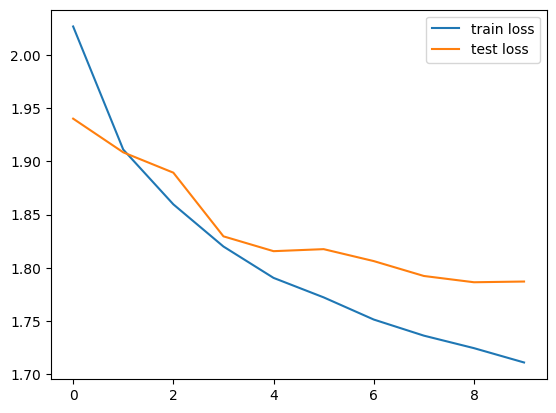

In [9]:
import seaborn as sns 
import warnings; warnings.filterwarnings(action="ignore")

sns.lineplot(x=range(10), y=loss_per_epoch, label="train loss")
sns.lineplot(x=range(10), y=val_loss_per_epoch, label="test loss")